In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [1]:
import functools
import time
import math
import tensorflow as tf
from tensorflow import keras
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

Defining constants

In [3]:
DEVICE = 'GPU/:0'

DATASET_DIR = '../datasets/Dataset-IoT/'
NETFLOW_DIR = DATASET_DIR + 'MC/NetFlow/'

# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets'
# MC_I_SECOND: Has infected data from Mirai botnets
# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'

data_set_files = [r'MC_I{}.csv'.format(index) for index in range(1, 4)]
data_set_files.insert(0, r'MC_L.csv')
print (data_set_files)

['MC_L.csv', 'MC_I1.csv', 'MC_I2.csv', 'MC_I3.csv']


Loading the Dataset

In [4]:
legitimate_file_path = NETFLOW_DIR + MC_L

LABEL_COLUMN = 'Label'

#reading data
df = pd.read_csv (legitimate_file_path)

# for file in data_set_files:
#     aux_df = pd.read_csv(NETFLOW_DIR + file)
#     df = pd.concat([df, aux_df], ignore_index=True)

aux_df = pd.read_csv(NETFLOW_DIR + data_set_files[1])
df = pd.concat([df, aux_df], ignore_index=True)

#making the final DataFrame
df = df.sample(frac=1, random_state=math.ceil(time.time()), )
df = df.drop(df.columns[0], axis=1)
df.describe()

nUniques = df.nunique()
for column, nUnique in zip (df.columns, nUniques):
    if(nUnique == 1):
        df.drop(axis='columns', columns=column, inplace=True)
df

,Label,ts,te,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
157276,1,2018-11-11 03:44:19,2018-11-11 03:44:19,0.0,192.168.1.109,83142209155,14309,23.0,TCP,....S.,1.0,40.0
310900,1,2018-11-11 04:02:54,2018-11-11 04:02:54,0.0,192.168.1.109,17.85.84.168,33143,23.0,TCP,....S.,1.0,40.0
163506,1,2018-11-11 03:45:06,2018-11-11 03:45:06,0.0,192.168.1.109,156241248212,10607,23.0,TCP,....S.,1.0,40.0
97313,1,2018-11-11 03:37:03,2018-11-11 03:37:03,0.0,192.168.1.109,76.49.28.161,8421,23.0,TCP,....S.,1.0,40.0
215220,1,2018-11-11 03:51:14,2018-11-11 03:51:14,0.0,192.168.1.109,148.25.4.33,33832,23.0,TCP,....S.,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6472,1,2018-11-11 03:26:22,2018-11-11 03:26:22,0.0,192.168.1.109,91.77.235.12,28244,81.0,TCP,....S.,1.0,40.0
112718,0,2018-11-11 03:38:54,2018-11-11 03:38:54,0.0,192.168.1.109,224.0.0.251,0,0.0,IGMP,......,1.0,32.0
227714,1,2018-11-11 03:52:43,2018-11-11 03:52:43,0.0,192.168.1.109,220.53.254.248,32898,23.0,TCP,....S.,1.0,40.0
358337,1,2018-11-11 04:08:40,2018-11-11 04:08:40,0.0,192.168.1.109,78.166.169.28,25188,23.0,TCP,....S.,1.0,40.0


# Encoding the Categorical Columns

In [5]:
from sklearn import preprocessing

cat_cols, num_cols = df.columns[df.dtypes == 'O'], df.columns[df.dtypes != 'O']
num_cols = num_cols[1:]

categories = [df[column].unique() for column in df[cat_cols]]

categorical_encoder = preprocessing.OrdinalEncoder(categories=categories)
categorical_encoder.fit(df[cat_cols])
df[cat_cols] = categorical_encoder.transform(df[cat_cols])

df


,Label,ts,te,td,sa,da,sp,dp,pr,flg,ipkt,ibyt
157276,1,0.0,0.0,0.0,0.0,0.0,14309,23.0,0.0,0.0,1.0,40.0
310900,1,1.0,1.0,0.0,0.0,1.0,33143,23.0,0.0,0.0,1.0,40.0
163506,1,2.0,2.0,0.0,0.0,2.0,10607,23.0,0.0,0.0,1.0,40.0
97313,1,3.0,3.0,0.0,0.0,3.0,8421,23.0,0.0,0.0,1.0,40.0
215220,1,4.0,4.0,0.0,0.0,4.0,33832,23.0,0.0,0.0,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6472,1,456.0,455.0,0.0,0.0,329109.0,28244,81.0,0.0,0.0,1.0,40.0
112718,0,1264.0,1263.0,0.0,0.0,639.0,0,0.0,3.0,3.0,1.0,32.0
227714,1,278.0,908.0,0.0,0.0,329110.0,32898,23.0,0.0,0.0,1.0,40.0
358337,1,1169.0,1170.0,0.0,0.0,329111.0,25188,23.0,0.0,0.0,1.0,40.0


Splitting the data

In [6]:
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

train, test = train_test_split (df, test_size=0.2)
train, val = train_test_split (train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train_labels = np.array (train.pop('Label'))
bool_train_labels = train_labels != 0
val_labels = np.array(val.pop('Label'))
test_labels = np.array (test.pop('Label'))

train_features = np.array(train)
val_features = np.array(val)
test_features = np.array(test)



230794 train examples
57699 validation examples
72124 test examples


In [7]:
neg, pos = np.bincount(df['Label'])
print ("Negative Examples: {}".format(neg))
print ("Positive Examples: {}".format(pos))

#dropping the labels columns
df = df.drop(df.columns[0], axis=1)

Negative Examples: 2005
Positive Examples: 358612


# Scaling the data

In [8]:
#getting the index of the numerical columns
index = [df.columns.get_loc(c) for c in num_cols]
index = np.array(index)

cat_index = [df.columns.get_loc(c) for c in cat_cols]
cat_index = np.array(index)

scaler = StandardScaler()
train_features[:, index] = scaler.fit_transform(train_features[:, index])

val_features[:, index] = scaler.transform(val_features[:, index])

test_features[:, index] = scaler.transform(test_features[:, index])

train_features[:, index] = np.clip(train_features[:, index], -5, 5)
val_features[:, index] = np.clip(val_features[:, index], -5, 5)
test_features[:, index] = np.clip(test_features[:, index], -5, 5)


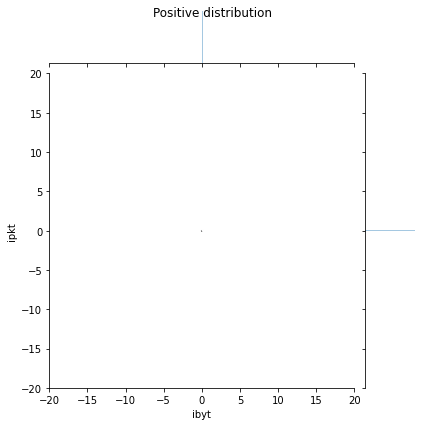

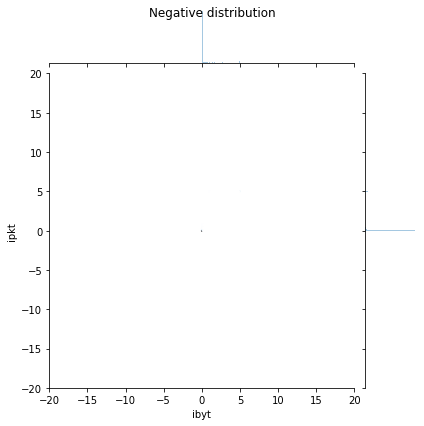

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train.columns)

sns.jointplot(pos_df['ibyt'], pos_df['ipkt'],
              kind='hex', xlim = (-20,20), ylim = (-20,20))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['ibyt'], neg_df['ipkt'],
              kind='hex', xlim = (-20,20), ylim = (-20,20))
_ = plt.suptitle("Negative distribution")

Making the df into a dataset

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


hidden_layer_size = 16
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(hidden_layer_size, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(hidden_layer_size, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)

    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.predict(train_features[:10])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [14]:
BATCH_SIZE=2048

results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print ("Loss: {:0.4f}".format(results[0]))

Loss: 42221.5430


In [12]:
import os
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Comparing with/without better initialization

In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0,
    callbacks=[tensorboard_callback])

In [19]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 3617), started 0:00:38 ago. (Use '!kill 3617' to kill it.)

In [21]:
#initial bias for imbalanced data
initial_bias = np.log([neg/pos])

model = make_model(output_bias=initial_bias)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0,
    callbacks=[tensorboard_callback])

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

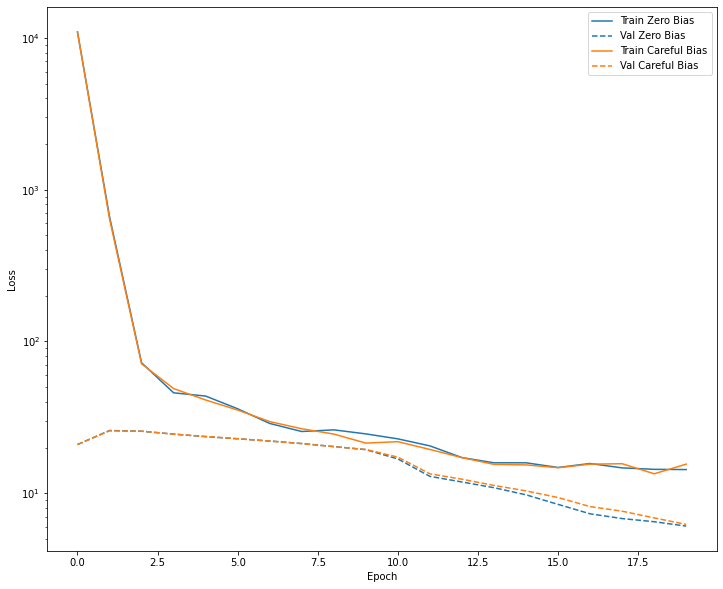

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [15]:
EPOCHS = 100
BATCH_SIZE = 2048
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

initial_bias = np.log([neg/pos])

model = make_model(output_bias=initial_bias)
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
113/113 [==============================] - 1s 9ms/step - loss: 1512.2642 - tp: 184470.0000 - fp: 992.0000 - tn: 314.0000 - fn: 45018.0000 - accuracy: 0.8006 - precision: 0.9947 - recall: 0.8038 - auc: 0.5245 - val_loss: 16.6176 - val_tp: 57360.0000 - val_fp: 337.0000 - val_tn: 0.0000e+00 - val_fn: 2.0000 - val_accuracy: 0.9941 - val_precision: 0.9942 - val_recall: 1.0000 - val_auc: 0.5014
Epoch 2/100
113/113 [==============================] - 0s 4ms/step - loss: 15.6047 - tp: 223345.0000 - fp: 1147.0000 - tn: 159.0000 - fn: 6143.0000 - accuracy: 0.9684 - precision: 0.9949 - recall: 0.9732 - auc: 0.5539 - val_loss: 16.2485 - val_tp: 57360.0000 - val_fp: 337.0000 - val_tn: 0.0000e+00 - val_fn: 2.0000 - val_accuracy: 0.9941 - val_precision: 0.9942 - val_recall: 1.0000 - val_auc: 0.5028
Epoch 3/100
113/113 [==============================] - 1s 5ms/step - loss: 11.3382 - tp: 224829.0000 - fp: 1082.0000 - tn: 224.0000 - fn: 4659.0000 - accuracy: 0.9751 - precision: 0.9952 - recal

113/113 [==============================] - 0s 4ms/step - loss: 1.4231 - tp: 229243.0000 - fp: 1170.0000 - tn: 136.0000 - fn: 245.0000 - accuracy: 0.9939 - precision: 0.9949 - recall: 0.9989 - auc: 0.7875 - val_loss: 1.5127 - val_tp: 57362.0000 - val_fp: 337.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9942 - val_precision: 0.9942 - val_recall: 1.0000 - val_auc: 0.7933
Epoch 42/100
113/113 [==============================] - 0s 4ms/step - loss: 1.3180 - tp: 229204.0000 - fp: 1160.0000 - tn: 146.0000 - fn: 284.0000 - accuracy: 0.9937 - precision: 0.9950 - recall: 0.9988 - auc: 0.7959 - val_loss: 1.3800 - val_tp: 57357.0000 - val_fp: 337.0000 - val_tn: 0.0000e+00 - val_fn: 5.0000 - val_accuracy: 0.9941 - val_precision: 0.9942 - val_recall: 0.9999 - val_auc: 0.8164
Epoch 43/100
113/113 [==============================] - 0s 4ms/step - loss: 1.0407 - tp: 229161.0000 - fp: 1137.0000 - tn: 169.0000 - fn: 327.0000 - accuracy: 0.9937 - precision: 0.9951 - recall: 0.9986 - auc:

Epoch 82/100
113/113 [==============================] - 1s 5ms/step - loss: 0.3017 - tp: 229244.0000 - fp: 1112.0000 - tn: 194.0000 - fn: 244.0000 - accuracy: 0.9941 - precision: 0.9952 - recall: 0.9989 - auc: 0.8636 - val_loss: 0.5337 - val_tp: 57359.0000 - val_fp: 280.0000 - val_tn: 57.0000 - val_fn: 3.0000 - val_accuracy: 0.9951 - val_precision: 0.9951 - val_recall: 0.9999 - val_auc: 0.8294
Epoch 83/100
113/113 [==============================] - 1s 5ms/step - loss: 0.7981 - tp: 229295.0000 - fp: 1138.0000 - tn: 168.0000 - fn: 193.0000 - accuracy: 0.9942 - precision: 0.9951 - recall: 0.9992 - auc: 0.8526 - val_loss: 0.6031 - val_tp: 57350.0000 - val_fp: 293.0000 - val_tn: 44.0000 - val_fn: 12.0000 - val_accuracy: 0.9947 - val_precision: 0.9949 - val_recall: 0.9998 - val_auc: 0.8859
Epoch 84/100
113/113 [==============================] - 1s 5ms/step - loss: 0.5342 - tp: 229385.0000 - fp: 1087.0000 - tn: 219.0000 - fn: 103.0000 - accuracy: 0.9948 - precision: 0.9953 - recall: 0.9996 - 

In [16]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [28]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 3617), started 0:04:02 ago. (Use '!kill 3617' to kill it.)

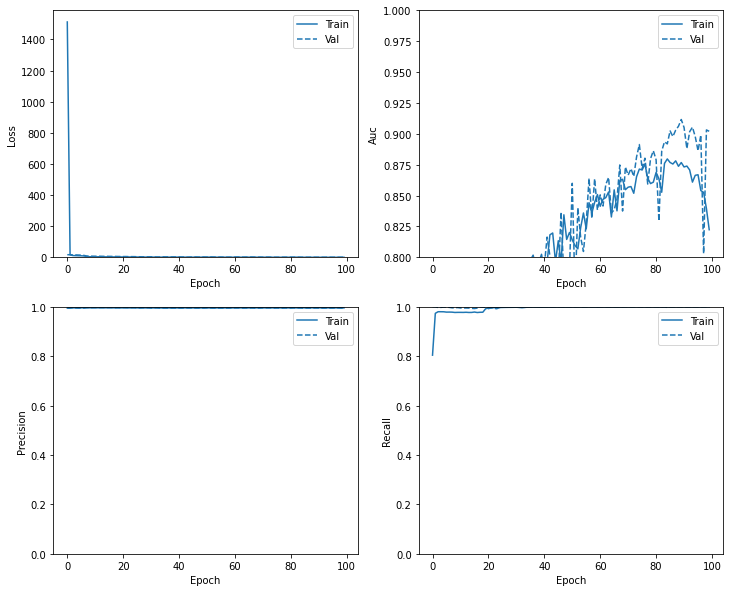

In [17]:
plot_metrics(baseline_history)


# Confusion Matrix

In [48]:
val_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)

In [49]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  1.464199423789978
tp :  57208.0
fp :  299.0
tn :  9.0
fn :  183.0
accuracy :  0.9916462898254395
precision :  0.9948006272315979
recall :  0.9968113303184509
auc :  0.7687747478485107

Legitimate Transactions Detected (True Negatives):  9
Legitimate Transactions Incorrectly Detected (False Positives):  299
Fraudulent Transactions Missed (False Negatives):  183
Fraudulent Transactions Detected (True Positives):  57208
Total Fraudulent Transactions:  57391


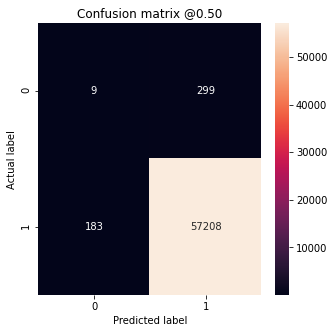

In [50]:
baseline_results = model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, val_predictions_baseline)

In [25]:
total = pos + neg
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight={0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 89.93
Weight for class 1: 0.50


In [30]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping, tensorboard_callback],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 

Epoch 1/100
113/113 [==============================] - 1s 11ms/step - loss: 6468.9487 - tp: 172641.0000 - fp: 437.0000 - tn: 1177.0000 - fn: 114238.0000 - accuracy: 0.6025 - precision: 0.9975 - recall: 0.6018 - auc: 0.6500 - val_loss: 20.0810 - val_tp: 53991.0000 - val_fp: 82.0000 - val_tn: 256.0000 - val_fn: 3370.0000 - val_accuracy: 0.9402 - val_precision: 0.9985 - val_recall: 0.9412 - val_auc: 0.8495
Epoch 2/100
113/113 [==============================] - 1s 5ms/step - loss: 1318.6174 - tp: 181480.0000 - fp: 386.0000 - tn: 890.0000 - fn: 48038.0000 - accuracy: 0.7902 - precision: 0.9979 - recall: 0.7907 - auc: 0.7450 - val_loss: 14.1115 - val_tp: 53881.0000 - val_fp: 77.0000 - val_tn: 261.0000 - val_fn: 3480.0000 - val_accuracy: 0.9384 - val_precision: 0.9986 - val_recall: 0.9393 - val_auc: 0.8573
Epoch 3/100
113/113 [==============================] - 1s 5ms/step - loss: 375.3545 - tp: 183001.0000 - fp: 339.0000 - tn: 937.0000 - fn: 46517.0000 - accuracy: 0.7970 - precision: 0.9982 -

In [54]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 25415), started 1:17:27 ago. (Use '!kill 25415' to kill it.)

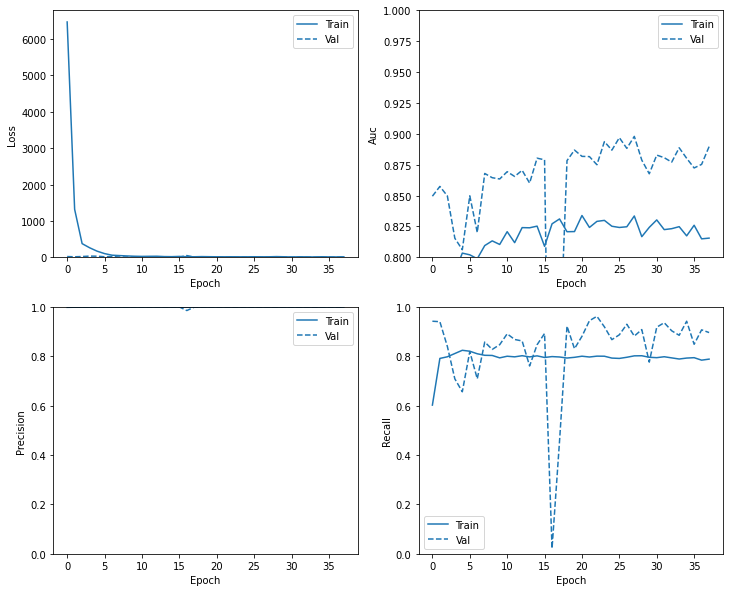

In [33]:
plot_metrics(weighted_history)


loss :  0.4120755195617676
tp :  49501.0
fp :  48.0
tn :  260.0
fn :  7890.0
accuracy :  0.8624239563941956
precision :  0.9990312457084656
recall :  0.8625220060348511
auc :  0.9276014566421509

Legitimate Transactions Detected (True Negatives):  260
Legitimate Transactions Incorrectly Detected (False Positives):  48
Fraudulent Transactions Missed (False Negatives):  7890
Fraudulent Transactions Detected (True Positives):  49501
Total Fraudulent Transactions:  57391


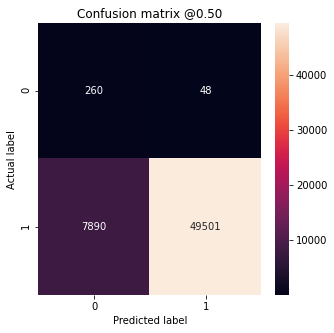

In [56]:
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(val_features, val_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(val_labels, val_predictions_weighted)